In [1]:
import numpy as np

In [2]:
import symlens

In [4]:
import pathlib

In [10]:
import utilities as u

In [11]:
from pixell import enmap, utils as putils

In [42]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

csfont = {'fontname':'Latin Modern Roman'}
font = font_manager.FontProperties(family='Latin Modern Roan',
                                   style='normal', size = 8)


In [5]:
directory = pathlib.Path('/scratch/r/rbond/omard/CORI17112020/extract_sehgal/LensQuEst-1/spectracmb/')

In [82]:
ell, clunlen, cllen, _, ftot, _, clftszmanu = np.loadtxt(directory.parent/'spectra_lensqest_un_len_detectnoise_fftot_fg_ftSZ.txt', unpack = True)

In [12]:
sims_directory = '../extract_sehgal/manusmaps/flat_maps_large/latestmaps13092020/'

In [13]:
WR = u.write_read(sims_directory)

In [14]:
changemap = lambda x: enmap.enmap(x, wcs)

In [17]:
mapsObjA = u.mapNamesObj(148)

In [21]:
C = u.Converting()

In [22]:
LoadA = u.LoadfftedMaps(mapsObj = mapsObjA, WR = WR, ConvertingObj = C, changemap = changemap, getfft = u.fft)

In [23]:
shape = LoadA.read_shape()

In [24]:
lonCenter, latCenter = 0, 0
shape, wcs = enmap.geometry(shape = shape, res = 1.*putils.arcmin, pos = (lonCenter, latCenter))
modlmap = enmap.modlmap(shape, wcs)

In [25]:
cmb0_fft, cmb1_fft, fg_fft_masked_A1, fg_gaussian_fft_masked_A1, fg_fft_masked_A2, fg_gaussian_fft_masked_A2, kappa_fft_masked, gal_fft_map = LoadA.read_all('tsz', 0)

In [83]:
logTT = np.log(cllen)
theory2dps_lensed_CMB = u.interpolate(ell, cllen, modlmap)
theory2dps_unlensed_CMB = u.interpolate(ell, clunlen, modlmap)
grad_theory2dps_unlensed_CMB = u.interpolate(ell, np.gradient(logTT, np.log(ell)), modlmap)

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [164]:
feed_dict = {}
feed_dict['uC_T_T'] = theory2dps_unlensed_CMB
feed_dict['tC_A_T_A_T'] = u.interpolate(ell, ftot, modlmap)
feed_dict['tC_A_T_B_T'] = u.interpolate(ell, ftot, modlmap)
feed_dict['tC_B_T_B_T'] = u.interpolate(ell, ftot, modlmap)
feed_dict['duC_T_T'] = grad_theory2dps_unlensed_CMB

In [165]:
est = 'hu_ok'
lmin_A, lmax_A = 30, 3500
field_names_A = ['A', 'B']

In [166]:
A = u.Estimator(shape, wcs, feed_dict, est, lmin_A, lmax_A,
                                    field_names = field_names_A, groups = None, Lmin = 20, Lmax = 6000,
                                    hardening = None, XY = 'TT')

In [132]:
rec_fg_map_A = A.reconstruct(fg_fft_masked_A1, fg_fft_masked_A2)
rec_fg_gauss_map_A = A.reconstruct(fg_gaussian_fft_masked_A1, fg_gaussian_fft_masked_A2)

In [133]:
Binner = u.Binner(shape, wcs, lmin = 1, lmax = 4000, deltal = 50, log = True, nBins = 21)

In [134]:
el, clfg_A_B = Binner.bin_maps(rec_fg_map_A, rec_fg_map_A, pixel_units = True)
el, clfg_gauss_A_B = Binner.bin_maps(rec_fg_gauss_map_A, rec_fg_gauss_map_A, pixel_units = True)
trispectrum_A_B = clfg_A_B-clfg_gauss_A_B

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [135]:
sAl = symlens.A_l(shape, wcs, feed_dict, est, "TT", xmask = A.xmask, ymask = A.ymask, field_names = field_names_A)

In [136]:
feed_dict['A'] = fg_fft_masked_A1

In [137]:
sukappa = symlens.unnormalized_quadratic_estimator(shape,wcs,feed_dict,est,"TT",xmask=A.xmask,ymask=A.ymask, xname = 'A_l1', yname = 'A_l2', field_names = ['A', 'A'])
snkappa = sAl * sukappa

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


In [138]:
feed_dict['A'] = fg_gaussian_fft_masked_A2
sukappa = symlens.unnormalized_quadratic_estimator(shape,wcs,feed_dict,est,"TT",xmask=A.xmask,ymask=A.ymask, xname = 'A_l1', yname = 'A_l2', field_names = ['A', 'A'])
snkappag = sAl * sukappa

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
el, primary_A = Binner.bin_maps(kappa_fft_masked, rec_fg_map_A, pixel_units = True)
el, primary_B = Binner.bin_maps(kappa_fft_masked, rec_fg_map_A, pixel_units = True)
primary_A_B = primary_A+primary_B

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [140]:
el, clfg_A_B = Binner.bin_maps(snkappa, snkappa, pixel_units = True)
el, clfg_gauss_A_B = Binner.bin_maps(snkappag, snkappag, pixel_units = True)
trispectrum_A_B_symlens = clfg_A_B-clfg_gauss_A_B

/home/r/rbond/omard/.local/lib/python3.6/site-packages/orphics/maps.py:484: RuntimeWarning: overflow encountered in multiply
  res = np.real(np.conjugate(kmap1)*kmap2)*norm
/home/r/rbond/omard/.local/lib/python3.6/site-packages/orphics/maps.py:484: RuntimeWarning: invalid value encountered in multiply
  res = np.real(np.conjugate(kmap1)*kmap2)*norm


In [167]:
mapS1 = A.reconstruct(cmb0_fft, fg_fft_masked_A1) + A.reconstruct(fg_fft_masked_A1, cmb0_fft)
mapS2 = A.reconstruct(cmb1_fft, fg_fft_masked_A1) + A.reconstruct(fg_fft_masked_A1, cmb1_fft)

el, secondary_A_B = Binner.bin_maps(mapS1, mapS2, pixel_units = True)
secondary_A_B *= 2

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [175]:
mapS1 = A.reconstruct(cmb0_fft, fg_fft_masked_A2)

In [176]:
mapS2 = A.reconstruct(fg_fft_masked_A2, cmb1_fft)

In [177]:
el, secondary_A_B_ = Binner.bin_maps(mapS1, mapS2, pixel_units = True)
secondary_A_B_*= 8

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [178]:
secondary_A_B/secondary_A_B_

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([nan, nan, nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [171]:
lCen, tris, prim, sec, _, _= np.loadtxt('/scratch/r/rbond/omard/CORI17112020/extract_sehgal/LensQuEst-1/out_txt/SH_3500.0_tris_prim_sec_0.txt', unpack = True)

In [172]:
P = u.Plotting('', 30, 2000, xscale = 'log')

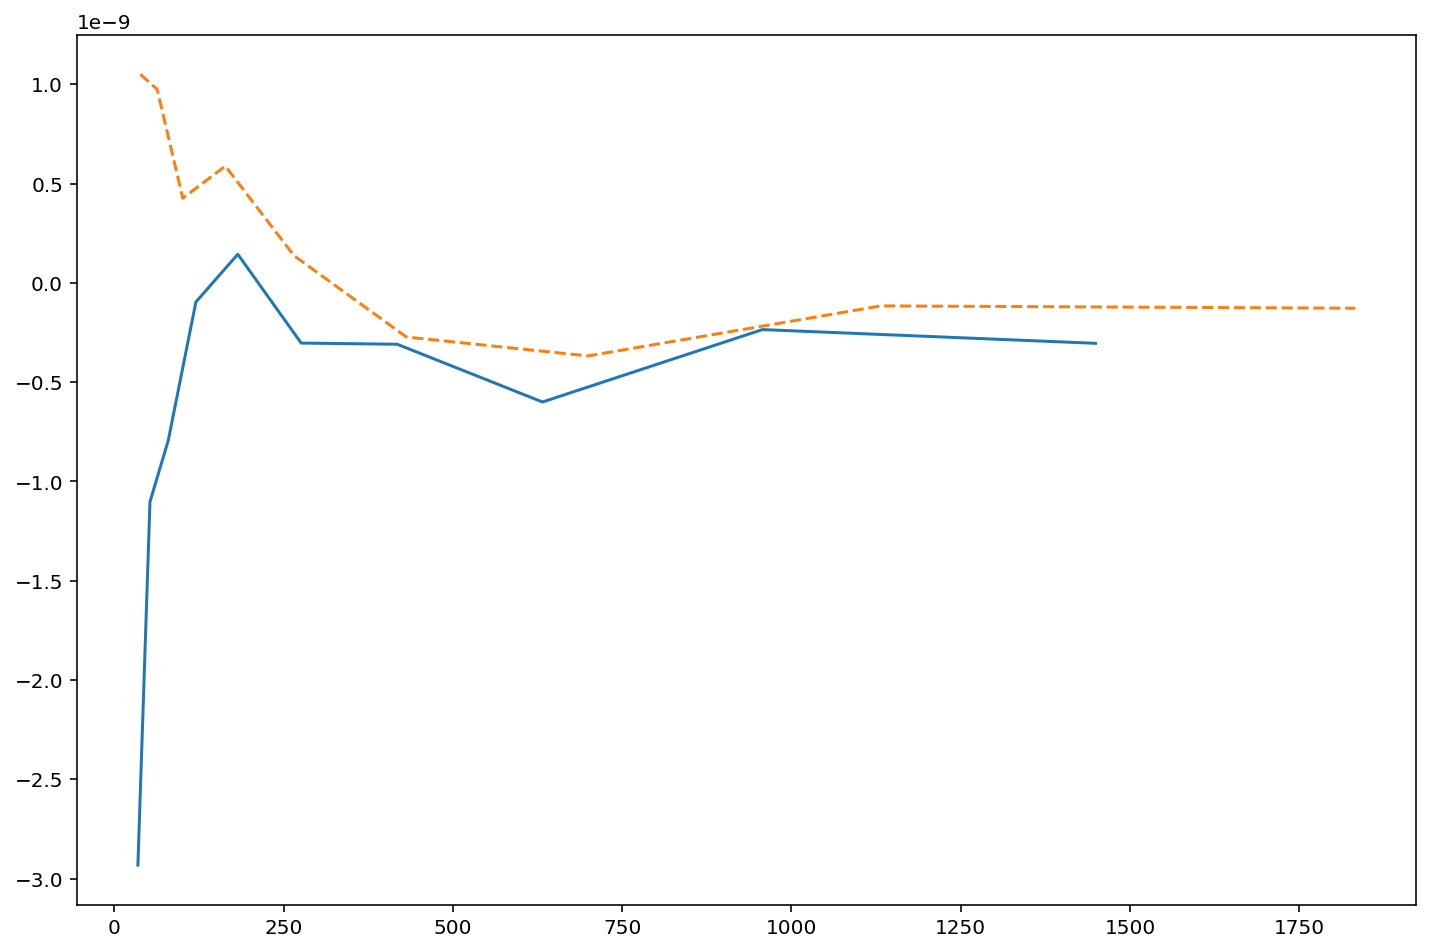

In [179]:
P.plotsel(el, secondary_A_B_)
P.plotsel(lCen, sec, ls = '--')

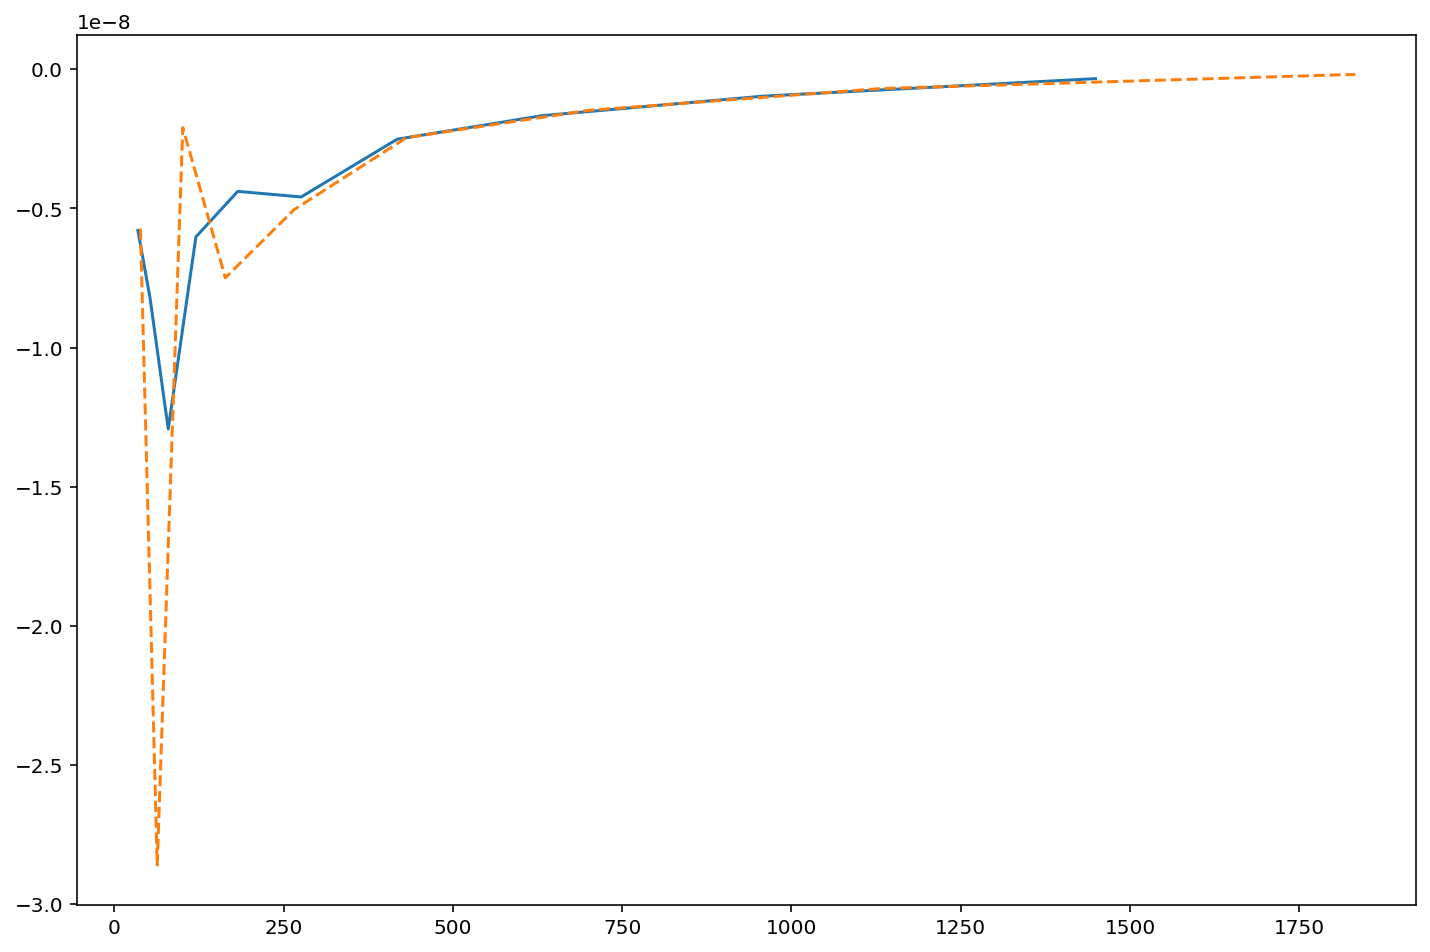

In [150]:
P.plotsel(el, primary_A_B)
P.plotsel(lCen, prim, ls = '--')

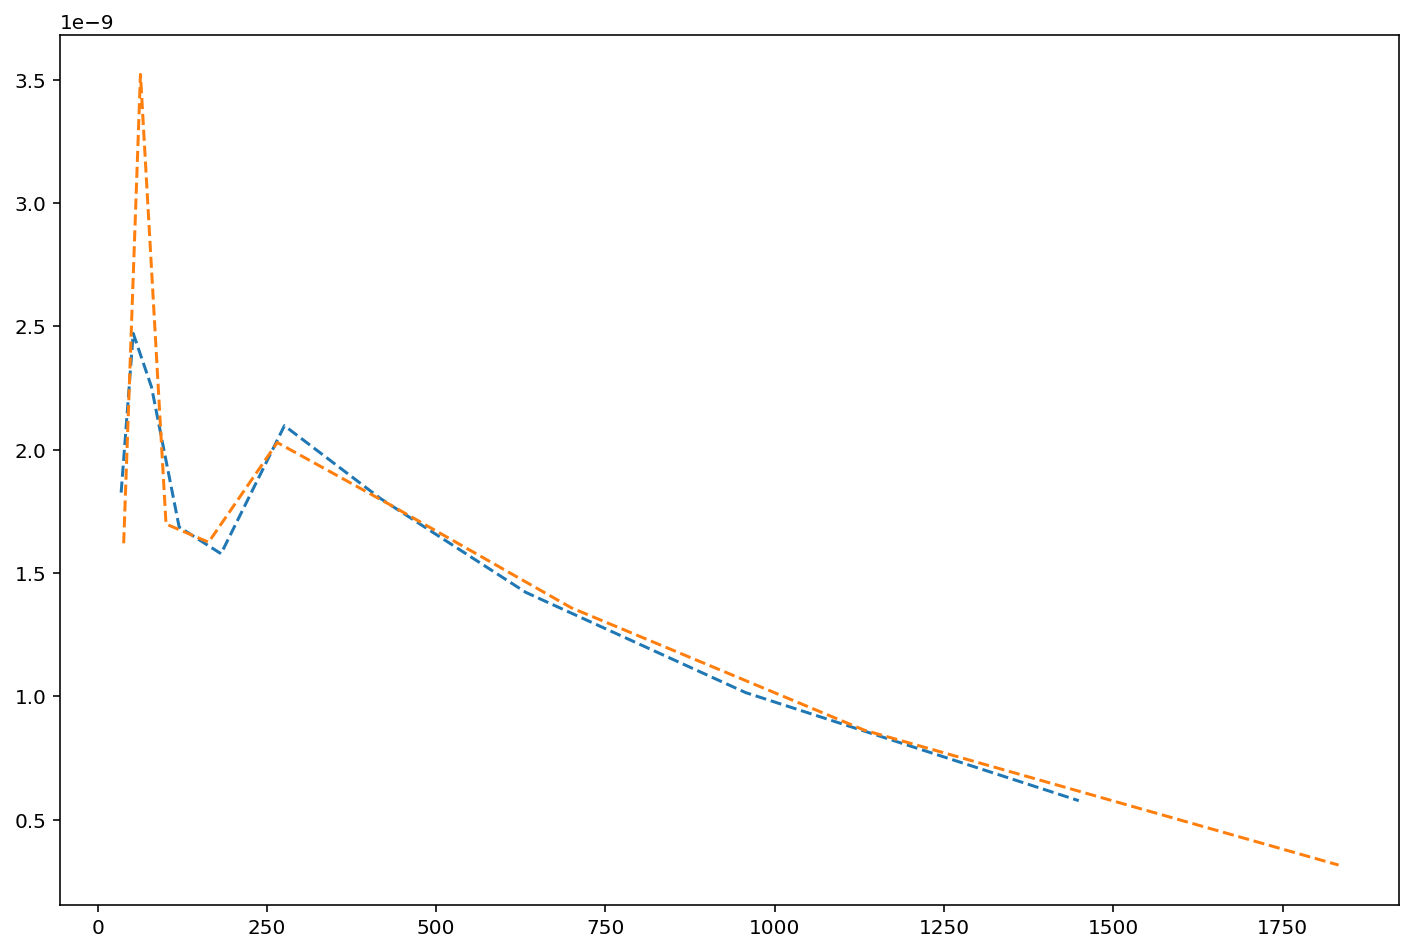

In [151]:
P.plotsel(el, trispectrum_A_B, ls = '--')
P.plotsel(lCen, tris, ls = '--')

In [ ]:
mapA0 =  A.reconstruct(fg_fft_masked_A1, cmb0_fft)+ A.reconstruct(cmb0_fft, fg_fft_masked_A2)
mapB1 = B.reconstruct(fg_fft_masked_B1, cmb1_fft) + A.reconstruct(cmb1_fft, fg_fft_masked_B2)
el, partial01 = Binner.bin_maps(mapA0, mapB1, pixel_units = True)

mapA1 = A.reconstruct(fg_fft_masked_A1, cmb1_fft)+ A.reconstruct(cmb1_fft, fg_fft_masked_A2)
mapB0 = B.reconstruct(fg_fft_masked_B1, cmb0_fft) + A.reconstruct(cmb0_fft, fg_fft_masked_B2)
el, partial10 = Binner.bin_maps(mapA1, mapB0, pixel_units = True)

secondary = partial01+partial10

In [180]:
len([])

0